In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.grid3d import GridPatchSampler, DataReaderHDF5

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
cfg = OmegaConf.load('../../config/config3d_patch.yaml')
cfg.dataset
data_path = cfg.dataset.data
data_group = cfg.dataset.group
info = cfg.dataset.info
infocolumn = cfg.dataset.column
val_set = cfg.dataset.val
patch_size = cfg.dataset.patch_size
patch_overlap = [15,15,15]

val_keys = [l.strip() for l in Path(val_set).open().readlines()]

In [3]:
info_df = pd.read_csv(info, index_col=0, dtype={'key': 'string', infocolumn: np.float32})


In [4]:
ds = GridPatchSampler(data_path,
                 val_keys[:1],
                 patch_size, patch_overlap,
                 out_channels=2,
                 out_dtype=np.float32,
                 image_group=data_group,
                 ReaderClass=DataReaderHDF5,
                 pad_args={'mode': 'constant'})


100%|██████████| 1/1 [00:00<00:00, 30.39it/s]


In [5]:
ckpt = '/home/raheppt1/projects/brainage/outputs/brainage/debug3d/2020-08-17/15-30-01/brainage/3c4qpm92/checkpoints/epoch=59.ckpt'
model = AgeModel3DVolume.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()

AgeModel3DVolume(
  (loss_criterion): l2_loss()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): VarNorm3d(
      (layer): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer4): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): VarNorm3d(
          (layer): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): VarNorm3d(
          (layer): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (d

In [6]:
device = torch.device('cuda:0')
model = model.to(device)

In [7]:
pred = {'key': [], 'pos0': [], 'pos1': [], 'pos2': [], 'y': [], 'yhat0': [], 'yhat1': []}
batch_size = 4
loader = DataLoader(ds, batch_size=batch_size, num_workers=1, drop_last=False, shuffle=False)

for sample in tqdm(loader):
    # predict
    x = sample['data'].float()
    x = x.to(device)
    position = sample['position'].float()
    y_hat = model(x, pos=None)

    # store map with predicted values
    shape = np.array(x.size())
    sample['data'] = np.einsum('ij,klm->ijklm', 
                               y_hat.detach().cpu().numpy(),
                               np.ones(shape[2:]))
    ds.add_processed_batch(sample)

    # store results
    for b in range(batch_size):
        key = sample['key'][b]
        y = info_df.loc[key][infocolumn]
        pred['key'].append(key)
        pred['pos0'].append(position[b,0].cpu().item())
        pred['pos1'].append(position[b,1].cpu().item())
        pred['pos2'].append(position[b,2].cpu().item())
        pred['y'].append(y)
        pred['yhat0'].append(y_hat[b,0].cpu().item())
        pred['yhat1'].append(y_hat[b,1].cpu().item())


100%|██████████| 1/1 [00:12<00:00, 12.03s/it]



In [13]:
np.mean(pred['yhat0'])

49.723583384165686

In [8]:
z = ds.get_assembled_data()
img = z['100000'][:]
img.shape

(2, 100, 125, 105)

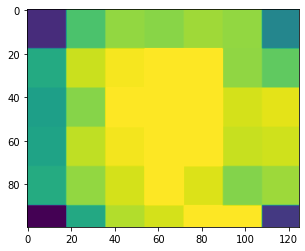

In [15]:
plt.imshow(img[0].max(axis=2), vmin=40, vmax=60)

In [71]:
ds = GridPatchSampler(data_path,
                 val_keys[:1],
                 patch_size, [5,5,5],
                 out_channels=1,
                 out_dtype=np.float32,
                 image_group=data_group,
                 ReaderClass=DataReaderHDF5,
                 pad_args={'mode': 'constant'})

100%|██████████| 1/1 [00:00<00:00, 44.11it/s]


In [72]:
loader = DataLoader(ds, batch_size=1, num_workers=1, drop_last=False, shuffle=False)
results = {'position': {}, 'patch': {}, 'heatmap': {}}
for key in val_keys[:1]:
    results['position'][key] = []
    results['patch'][key] = []
    results['heatmap'][key] = []
for sample in tqdm(loader):
    # predict
    x = sample['data'].float()
    x = x.to(device)
    position = sample['position'].float()
    position = position.to(device)
    y_hat, heatmap = model.gradcam(x, pos=None)

    # store raw heatmap
    key = sample['key'][0]
    results['position'][key].append(position.cpu().numpy())
    results['patch'][key].append(sample['data'][0, 0].cpu().numpy())
    results['heatmap'][key].append(heatmap.detach().cpu().numpy())

    # store zoomed heatmap
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = heatmap/heatmap.max()
    zoom = np.array(shape[2:])/np.array(heatmap.shape)
    heatmap_zoomed = scipy.ndimage.zoom(heatmap, zoom, order=0)
    sample['data'] = heatmap_zoomed[np.newaxis, np.newaxis,...]
    ds.add_processed_batch(sample)


100%|██████████| 1/1 [00:07<00:00,  7.57s/it]



In [39]:
for key in val_keys[:1]:
    results['position'][key] = np.stack(results['position'][key], axis=0)
    results['patch'][key] = np.stack(results['patch'][key], axis=0)
    results['heatmap'][key] = np.stack(results['heatmap'][key], axis=0)

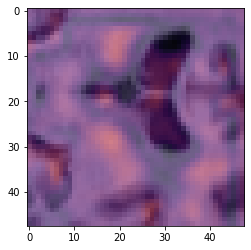

In [132]:
idx = 16
patch = results['patch']['100000'][idx].astype(np.float32)
hmap = results['heatmap']['100000'][idx].astype(np.float32)
hmap = hmap/hmap.max()
zoom = np.array(patch.shape)/np.array(hmap.shape)
hmap_zoomed = scipy.ndimage.zoom(hmap, zoom, order=3)
plt.imshow(patch[:,28,:], cmap='gray')
plt.imshow(hmap_zoomed[:,28,:], cmap='inferno', alpha=0.6, vmin=0, vmax=1.0)


In [54]:
hmap_zoomed.shape

(48, 48)

In [89]:
z = ds.get_assembled_data()
img = z['100000'][:]
img.shape

(1, 100, 125, 105)

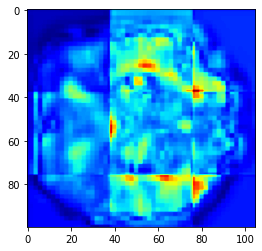

In [92]:
plt.imshow(img[0][:,40,:], cmap='jet')

In [ ]:
oom = np.array(img.shape)/np.array(hmap.shape)
heatmap_zoomed = scipy.ndimage.zoom(hmap, zoom, order=0)

In [135]:
shape

array([ 4,  2, 48, 48, 48])

In [138]:
res = np.array(res)

In [213]:
z = ds.get_assembled_data()
img = z['100000'][:]

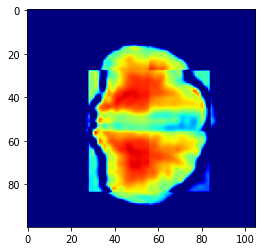

In [237]:
plt.imshow(img[0,:,100,:],cmap='jet',vmin=0.5,vmax=1.0)